In [1]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


print("Running...")


thr_std=0.2


E = Events("CheatedRecoFile_1.root")


view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")


u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x


v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x

Running...


In [2]:
def AoI(plane, event_number, thresholding=True, no_std=thr_std):
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z[event_number]
        AoI_truevtxx = u_truevtx_x[event_number]
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z[event_number]
        AoI_truevtxx = v_truevtx_x[event_number]
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z[event_number]
        AoI_truevtxx = w_truevtx_x[event_number]
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
    
    return AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx

In [3]:
def plotter(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)


    
    plt.scatter(AoI_z, AoI_x, c=AoI_adc, cmap="viridis")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")

    return 0


In [4]:
def least_z(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    min_z = np.amin(AoI_z)
    ind = np.where(min_z)[0]
    min_x = AoI_x[ind]
    #print("Least z prediction for vertex location: (x-position, z-position, plane)=", min_x, min_z, plane)
    return min_z, min_x

In [5]:
def phi_hist(plane, event_number, thresholding=True, no_std=thr_std, leastz=False, centre_coord=(0,0), no_sectors=12, centre=0, printhist=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    if leastz:
        centre_coord = least_z(plane, event_number, thresholding, no_std)
    
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre))
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    
    if printhist:
        plt.hist(hist_data, hist_bins)
        plt.show()

    return norm_score

In [56]:
def rfunc(r):
    return 1/((r+0.01)**(1/2))



def rphi(plane, event_number, thresholding=True, no_std=thr_std, centre_coord=(0,0), func=rfunc, no_sectors=5, centre=0):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]
    
    cen_r = (centred_x**2 + centred_z**2)**0.5
    #distance from central point to every other point
    

    #make the problem tractable (solvable)
    
    weight = rfunc(cen_r)

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre), weights=weight)
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    

    return norm_score

In [57]:
def optimise_phi(plane, event_number, thresholding=True, no_std=thr_std, no_sectors=5, centre=0, plot=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    no_points = len(AoI_x)
    score_arr = np.zeros(no_points)
    for i in tqdm(range(no_points)):
        centre_co = (AoI_z[i], AoI_x[i])
        score_arr[i] = rphi(plane, event_number, centre_coord=centre_co)
    
    ind = np.argmax(score_arr)
    zmin, xmin = AoI_z[ind], AoI_x[ind]
    if plot:
        plotter(plane, event_number, thresholding, no_std)
        plt.plot(zmin, xmin, 'ro')
        plt.show()
    return zmin, xmin, score_arr[ind]

In [58]:
def accuracy(plane, function, no_events, thresholding=True, no_std=thr_std):
    Zvert = []
    Zvert_true = []
    Xvert = []
    Xvert_true = [] #avoid appends to lists; if you know how long the outputs are going to be, then assign the arrays to
                    #that length beforehand
    
    for i in tqdm(range(no_events)):
        AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, i, thresholding, no_std)
        Zvert_place, Xvert_place = function(plane, i)[0], function(plane, i)[1]
        Zvert.append(Zvert_place)
        Xvert.append(Xvert_place)
        Zvert_true.append(Zvert_true_place)
        Xvert_true.append(Xvert_true_place)
    
    '''
    print(Zvert_true)
    print(Zvert)
    print(Xvert_true)
    print(Xvert)
    '''
    
    delta_z = np.array(Zvert_true) - np.array(Zvert)
    delta_x = np.array(Xvert_true) - np.array(Xvert)
    delta_r2 = delta_z**2 + delta_x**2

    print(len(delta_r2))
    print(delta_r2)
    
    #data, bins = np.histogram(delta_r2)
    #delta_r2 = delta_r2[delta_r2 < 0.4e6]
    delta_r2 = np.sqrt(delta_r2)
    plt.hist(delta_r2, bins='auto')
    #plt.ylim(0, 400)
    plt.show()

    return delta_r2, np.percentile(delta_r2, 68)

100%|██████████████████████████████████████████████████████████████████████████████| 533/533 [00:00<00:00, 4081.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 859/859 [00:00<00:00, 4769.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 327/327 [00:00<00:00, 5309.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 5065.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5994.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5991.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 363/363 [00:00<00:00, 5039.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 852/852 [00:00<00:00, 4526.29it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 569/569 [00:00<00:00, 4817.67it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2772/2772 [00:00<00:00, 3128.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 3576.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 539/539 [00:00<00:00, 3148.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 3581.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 3209.57it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1287/1287 [00:00<00:00, 3167.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 330/330 [00:00<00:00, 4712.80it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 303/303 [00:00<00:00, 4146.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3332.78it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 531/531 [00:00<00:00, 4228.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 407/407 [00:00<00:00, 3404.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 561/561 [00:00<00:00, 3403.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 675/675 [00:00<00:00, 2846.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 3335.96it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 572/572 [00:00<00:00, 4667.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 3999.57it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 3202.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 604/604 [00:00<00:00, 4968.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 4952.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 4547.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 4774.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 396/396 [00:00<00:00, 3594.74it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 1032/1032 [00:00<00:00, 3799.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 4062.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 4696.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 326/326 [00:00<00:00, 5174.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 314/314 [00:00<00:00, 5501.62it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1088/1088 [00:00<00:00, 4577.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 3449.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 3798.46it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 768/768 [00:00<00:00, 4871.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 248/248 [00:00<00:00, 5063.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 343/343 [00:00<00:00, 5271.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 4722.43it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 4710.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 5276.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 4893.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 5125.45it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 677/677 [00:00<00:00, 5067.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 336/336 [00:00<00:00, 5596.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 652/652 [00:00<00:00, 4946.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4566.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4923.98it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1242/1242 [00:00<00:00, 4207.56it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1366/1366 [00:00<00:00, 4116.10it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1443/1443 [00:00<00:00, 4372.09it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 977/977 [00:00<00:00, 4519.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 5622.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 5053.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 5001.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 700/700 [00:00<00:00, 4818.65it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1072/1072 [00:00<00:00, 4431.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 279/279 [00:00<00:00, 5575.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 5053.54it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 1631/1631 [00:00<00:00, 3591.27it/s]

100%|████████████████████████████████████████████████████████████████████████████| 3386/3386 [00:01<00:00, 2852.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 4844.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 5079.12it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 4302.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 302/302 [00:00<00:00, 5296.37it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 4399.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 4899.37it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 1228/1228 [00:00<00:00, 4146.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 4999.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 774/774 [00:00<00:00, 4894.66it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1018/1018 [00:00<00:00, 4583.86it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1457/1457 [00:00<00:00, 4059.68it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 5314.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 4633.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 856/856 [00:00<00:00, 4886.54it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 2246/2246 [00:00<00:00, 3549.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 449/449 [00:00<00:00, 5556.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 611/611 [00:00<00:00, 4901.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 771/771 [00:00<00:00, 4735.82it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1103/1103 [00:00<00:00, 4467.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 5052.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 5108.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [00:00<00:00, 4886.22it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 5514.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 732/732 [00:00<00:00, 4924.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 988/988 [00:00<00:00, 4677.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 746/746 [00:00<00:00, 4885.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 5046.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 4811.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 4847.13it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 4846.15it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 3668.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 3668.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 306/306 [00:00<00:00, 5320.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 642/642 [00:00<00:00, 4935.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 642/642 [00:00<00:00, 4807.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 293/293 [00:00<00:00, 5361.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 784/784 [00:00<00:00, 4987.02it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2470/2470 [00:00<00:00, 3522.97it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 5084.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 4937.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 374/374 [00:00<00:00, 5611.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 887/887 [00:00<00:00, 4709.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 5427.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 4667.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 5602.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 749/749 [00:00<00:00, 4709.15it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 5443.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 327/327 [00:00<00:00, 5483.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 5122.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 4909.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 4740.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 5626.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 5585.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 5009.23it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 4663.95it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 4870.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 810/810 [00:00<00:00, 4747.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 4785.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 4785.16it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1179/1179 [00:00<00:00, 4291.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 247/247 [00:00<00:00, 5480.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 247/247 [00:00<00:00, 5670.68it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 1002/1002 [00:00<00:00, 4431.44it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1443/1443 [00:00<00:00, 4089.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 357/357 [00:00<00:00, 5485.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 3778.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 4857.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 510/510 [00:00<00:00, 5228.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 5421.34it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1025/1025 [00:00<00:00, 4732.50it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 5115.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 4924.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 440/440 [00:00<00:00, 5330.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 659/659 [00:00<00:00, 4876.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 5593.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 5012.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 257/257 [00:00<00:00, 5582.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 5187.85it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 5363.41it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:00<00:00, 4711.49it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1282/1282 [00:00<00:00, 4248.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 322/322 [00:00<00:00, 5502.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 348/348 [00:00<00:00, 5562.46it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1094/1094 [00:00<00:00, 4469.79it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1752/1752 [00:00<00:00, 3978.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 302/302 [00:00<00:00, 5344.98it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 1458/1458 [00:00<00:00, 4068.41it/s]

100%|████████████████████████████████████████████████████████████████████████████| 3402/3402 [00:01<00:00, 2840.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 248/248 [00:00<00:00, 5474.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 248/248 [00:00<00:00, 5511.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 5030.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 381/381 [00:00<00:00, 5108.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 4975.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 5083.80it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 4980.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 5083.60it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1536/1536 [00:00<00:00, 4026.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 5325.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 4683.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 4944.61it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1066/1066 [00:00<00:00, 4356.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 4667.00it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 385/385 [00:00<00:00, 5450.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 675/675 [00:00<00:00, 4939.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 5000.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 5147.54it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1297/1297 [00:00<00:00, 4446.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 411/411 [00:00<00:00, 5513.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 5136.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 5144.71it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 5560.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 646/646 [00:00<00:00, 4909.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 4888.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 4888.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 4666.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 4670.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 4854.19it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1711/1711 [00:00<00:00, 3675.79it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 4285.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 4288.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 367/367 [00:00<00:00, 5202.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 616/616 [00:00<00:00, 4189.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 616/616 [00:00<00:00, 4733.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 813/813 [00:00<00:00, 4475.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 4813.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 5241.78it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 883/883 [00:00<00:00, 4670.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 412/412 [00:00<00:00, 5178.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 517/517 [00:00<00:00, 5038.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 608/608 [00:00<00:00, 4917.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 516/516 [00:00<00:00, 5289.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 284/284 [00:00<00:00, 5406.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 391/391 [00:00<00:00, 5622.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 795/795 [00:00<00:00, 4856.66it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 4708.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 4818.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 466/466 [00:00<00:00, 5408.71it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 5238.84it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 4857.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 4961.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 4864.99it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 5003.46it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 621/621 [00:00<00:00, 4791.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 434/434 [00:00<00:00, 5388.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 5065.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 5102.37it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1885/1885 [00:00<00:00, 4053.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 372/372 [00:00<00:00, 5666.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 388/388 [00:00<00:00, 5348.68it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 4857.74it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 1215/1215 [00:00<00:00, 4305.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 650/650 [00:00<00:00, 4975.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 953/953 [00:00<00:00, 4982.43it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 5000.43it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 4739.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 416/416 [00:00<00:00, 5362.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 5645.46it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2558/2558 [00:00<00:00, 3116.07it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 507/507 [00:00<00:00, 5302.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 338/338 [00:00<00:00, 5668.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 634/634 [00:00<00:00, 4815.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 4796.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 4909.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 344/344 [00:00<00:00, 5239.87it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1971/1971 [00:00<00:00, 3560.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2005.40it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 5376.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 295/295 [00:00<00:00, 5356.06it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1482/1482 [00:00<00:00, 4065.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 683/683 [00:00<00:00, 5014.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2939.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3013.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 5549.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4922.62it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 5380.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 5110.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 4837.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 914/914 [00:00<00:00, 4680.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 5116.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 5465.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 363/363 [00:00<00:00, 5497.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 4952.20it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 689/689 [00:00<00:00, 3710.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 392/392 [00:00<00:00, 4505.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 405/405 [00:00<00:00, 5357.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 4416.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 5047.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 865/865 [00:00<00:00, 3921.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 249/249 [00:00<00:00, 5409.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 5188.24it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 1684/1684 [00:00<00:00, 3408.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 3655.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 3925.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 394/394 [00:00<00:00, 3805.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 851/851 [00:00<00:00, 4177.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 440/440 [00:00<00:00, 3462.79it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1370/1370 [00:00<00:00, 3480.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 5191.54it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 823/823 [00:00<00:00, 3659.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 478/478 [00:00<00:00, 4759.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 4744.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 4743.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 4455.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 462/462 [00:00<00:00, 4737.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 768/768 [00:00<00:00, 4565.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 4281.92it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 506/506 [00:00<00:00, 5192.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 5530.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 5680.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 4828.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5009.92it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1176/1176 [00:00<00:00, 4271.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 4729.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 5454.35it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 956/956 [00:00<00:00, 4294.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 924/924 [00:00<00:00, 4708.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 472/472 [00:00<00:00, 5326.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 308/308 [00:00<00:00, 5396.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 386/386 [00:00<00:00, 5391.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 5453.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 5470.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 5103.08it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 293/293 [00:00<00:00, 5469.50it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2766/2766 [00:00<00:00, 3218.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 330/330 [00:00<00:00, 5492.67it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1372/1372 [00:00<00:00, 3926.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 518/518 [00:00<00:00, 5252.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 5146.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 5079.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 4730.80it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 275/275 [00:00<00:00, 5285.26it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2103/2103 [00:00<00:00, 3494.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 359/359 [00:00<00:00, 5478.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 5320.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 5540.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 382/382 [00:00<00:00, 5494.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 594/594 [00:00<00:00, 4924.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 5128.51it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 2635/2635 [00:00<00:00, 3103.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 411/411 [00:00<00:00, 5336.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 406/406 [00:00<00:00, 5513.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 5484.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 5406.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 454/454 [00:00<00:00, 5238.65it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1902/1902 [00:00<00:00, 3541.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 4454.85it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 2523/2523 [00:00<00:00, 3238.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 5175.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 4341.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 4341.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 625/625 [00:00<00:00, 4832.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 428/428 [00:00<00:00, 4407.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 284/284 [00:00<00:00, 5497.96it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 5386.31it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:00<00:00, 3953.25it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 5311.14it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 4853.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 517/517 [00:00<00:00, 4963.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 645/645 [00:00<00:00, 4975.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 5163.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 4942.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 4930.82it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 1817/1817 [00:00<00:00, 3816.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 4583.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 5022.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 506/506 [00:00<00:00, 5077.78it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1434/1434 [00:00<00:00, 4104.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 554/554 [00:00<00:00, 5009.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 4750.57it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 4991.09it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 5579/5579 [00:02<00:00, 2225.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 5607.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 5301.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 5181.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5534.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 5160.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 494/494 [00:00<00:00, 5394.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 292/292 [00:00<00:00, 5352.89it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 5713.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 5353.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 4810.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 3610.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 5502.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 369/369 [00:00<00:00, 5188.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 4648.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 4644.85it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 373/373 [00:00<00:00, 5354.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 5334.36it/s]

100%|████████████████████████████████████████████████████████████████████████████| 5102/5102 [00:02<00:00, 2291.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 356/356 [00:00<00:00, 5424.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 570/570 [00:00<00:00, 4992.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 4875.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 5087.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 339/339 [00:00<00:00, 5251.03it/s]



100%|██████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 5086.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 4875.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 5311.62it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 4700.34it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 4690.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 508/508 [00:00<00:00, 5372.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 324/324 [00:00<00:00, 5528.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 550/550 [00:00<00:00, 4925.84it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 4843.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 4442.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 330/330 [00:00<00:00, 5688.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 5495.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 5554.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 679/679 [00:00<00:00, 4969.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 629/629 [00:00<00:00, 4758.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 510/510 [00:00<00:00, 5172.61it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 410/410 [00:00<00:00, 5426.49it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 3251.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 4337.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 458/458 [00:00<00:00, 5411.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 431/431 [00:00<00:00, 5450.93it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1435/1435 [00:00<00:00, 4005.98it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 4730.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 4728.13it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 514/514 [00:00<00:00, 5263.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 5428.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 5549.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 5311.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 5120.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 5090.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 5931.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 5050.19it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 5319.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 5843.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 218/218 [00:00<00:00, 5119.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 218/218 [00:00<00:00, 4950.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 898/898 [00:00<00:00, 4627.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 535/535 [00:00<00:00, 5215.03it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1180/1180 [00:00<00:00, 4240.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 298/298 [00:00<00:00, 5663.74it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 5385.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 5077.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 5253.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 609/609 [00:00<00:00, 4771.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 563/563 [00:00<00:00, 4821.36it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2214/2214 [00:00<00:00, 3449.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 367/367 [00:00<00:00, 5474.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 379/379 [00:00<00:00, 5521.97it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 5578.47it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 5000.62it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 4998.23it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1227/1227 [00:00<00:00, 4251.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2989.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3037.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 5078.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 5023.34it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 352/352 [00:00<00:00, 5318.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 4907.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 5066.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 5370.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 413/413 [00:00<00:00, 5506.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 4627.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 4625.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 5531.84it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 5289.54it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1699/1699 [00:00<00:00, 3871.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 584/584 [00:00<00:00, 4987.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 520/520 [00:00<00:00, 4983.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 456/456 [00:00<00:00, 5323.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 535/535 [00:00<00:00, 5017.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 5490.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 4906.85it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 406/406 [00:00<00:00, 5598.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 4840.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 5102.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 577/577 [00:00<00:00, 4861.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 401/401 [00:00<00:00, 5526.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 271/271 [00:00<00:00, 5416.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 5142.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 4851.84it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 5473.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 586/586 [00:00<00:00, 4859.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 5343.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 456/456 [00:00<00:00, 5394.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 5755.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 5065.78it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1896/1896 [00:00<00:00, 3754.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 647/647 [00:00<00:00, 4915.27it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 5764.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 5698.01it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1101/1101 [00:00<00:00, 4331.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 406/406 [00:00<00:00, 5443.40it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1317/1317 [00:00<00:00, 4155.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 401/401 [00:00<00:00, 5446.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 5348.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 5389.08it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 469/469 [00:00<00:00, 4754.06it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1179/1179 [00:00<00:00, 4289.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 4644.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 4800.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 552/552 [00:00<00:00, 4776.17it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1727/1727 [00:00<00:00, 3699.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 5392.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 5462.75it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 5039.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 4842.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 449/449 [00:00<00:00, 5122.21it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5002.27it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4536.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 338/338 [00:00<00:00, 5397.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 3942.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 4598.87it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 588/588 [00:00<00:00, 4915.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 559/559 [00:00<00:00, 4966.34it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 4666.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 4666.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 4847.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 4143.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 412/412 [00:00<00:00, 5179.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 4936.95it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 415/415 [00:00<00:00, 5416.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 5158.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 5273.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 5473.34it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1088/1088 [00:00<00:00, 4296.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 338/338 [00:00<00:00, 5448.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 5197.40it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 5200.13it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 1335/1335 [00:00<00:00, 3171.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 5134.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 5213.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 5537.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2504.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2495.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 386/386 [00:00<00:00, 5322.14it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 4742.22it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 5000.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 4999.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 4753.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 4947.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 4709.33it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1724/1724 [00:00<00:00, 3061.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 4166.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 3249.85it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 671/671 [00:00<00:00, 4874.57it/s]

100%|████████████████████████████████████████████████████████████████████████████| 6099/6099 [00:03<00:00, 1964.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 485/485 [00:00<00:00, 5357.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [04:21<00:50,  1.19s/it]


100%|██████████████████████████████████████████████████████████████████████████████| 311/311 [00:00<00:00, 5489.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 654/654 [00:00<00:00, 4947.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 4652.21it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 5227.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 496/496 [00:00<00:00, 5409.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 389/389 [00:00<00:00, 5355.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 4952.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 5080.63it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 303/303 [00:00<00:00, 5648.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 468/468 [00:00<00:00, 5466.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 4863.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 4863.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 4272.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 3754.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 5000.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 824/824 [00:00<00:00, 4764.85it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 370/370 [00:00<00:00, 5321.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 657/657 [00:00<00:00, 4843.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 874/874 [00:00<00:00, 4809.95it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1088/1088 [00:00<00:00, 4579.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 442/442 [00:00<00:00, 5415.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 5757.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 5672.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 665/665 [00:00<00:00, 4901.79it/s]

100%|███████████████████████████

1000
[8.11924683e+02 1.84381695e+01 1.37846603e+01 9.97857749e-03
 8.52995664e-02 5.35484627e-02 6.64167188e+03 8.90929550e-02
 5.89036865e+02 6.21529358e+02 4.26715938e+05 5.30407205e-03
 2.28547382e+01 7.87681580e+02 1.40794528e+00 5.05826569e+02
 8.68302360e-02 3.07466574e-02 1.97824979e+00 1.74278088e+03
 8.43001633e+01 7.63709521e+03 2.25601555e-03 5.80988083e+01
 1.52030312e+05 6.14005518e+03 1.43186677e+00 2.56161137e+01
 7.47116500e+05 3.67892139e+03 2.73932114e+01 2.04731531e+03
 1.75458491e+00 1.03464365e+00 1.87450439e-01 8.04531872e-01
 1.30492419e-01 1.10911026e+01 3.79839688e+04 2.53102930e+03
 5.92664413e+01 4.98692799e+00 2.73788208e+02 1.21304132e-02
 1.36626110e+01 2.07168981e-01 6.99250698e+00 5.51724248e-02
 1.11197656e+03 8.48259338e+02 1.46378996e-02 3.83987378e+03
 2.03723633e+04 6.24135993e-02 1.20116058e+02 6.30316833e+02
 7.08736649e+01 2.62370312e+04 1.21547839e+03 3.94599375e+05
 1.90494657e-01 1.50800238e+01 3.63955274e-02 9.98622894e+00
 5.54108810e+00 5.0

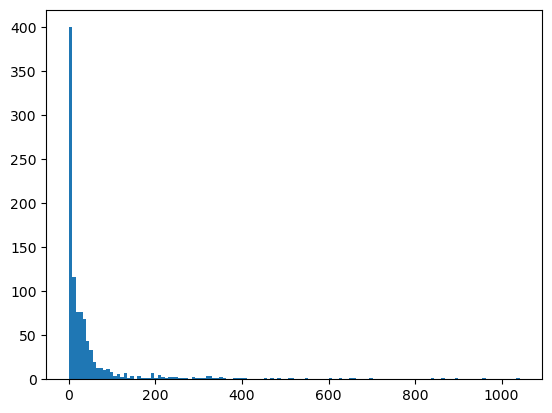

In [59]:
datadata, datadata2 = accuracy("v", optimise_phi, 1000)

In [60]:
print(datadata2)

32.848529052734385
